# MusicTrOCR (Luca Model) Demonstration

This notebook demonstrates the capabilities of the MusicTrOCR model for Optical Music Recognition (OMR). The model converts sheet music images into BeKern notation and visualizes the results.

## Architecture Overview
- **Vision Encoder**: ConvNeXt-Tiny pre-trained backbone
- **Decoder**: Transformer decoder with cross-attention
- **Output**: BeKern notation (symbolic music representation)
- **Visualization**: Verovio rendering engine for score display

---

## 1. Configuration
Set the paths for the demo image and trained model checkpoint.

In [1]:
img_name = "../demos/demo2.png"
ckpt_path = "../networks/checkpoints/luca_model/stage_2/best_checkpoint.pt"

## 2. Dependencies & Imports
Load required libraries and utility functions.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Import demo utilities
from utils import (
    load_model_and_vocab,
    preprocess_image,
    run_inference,
    decode_bekern_prediction,
    bekern_to_kern,
    render_music_score,
    visualize_results,
    demo_pipeline
)

print("Dependencies loaded successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

## 3. Model Loading
Load the trained MusicTrOCR model and BeKern vocabulary.

In [3]:
# Load model and vocabulary
print("Loading MusicTrOCR model...")

try:
    model, vocab_dict, id_to_token = load_model_and_vocab(
        ckpt_path=ckpt_path,
        vocab_path="../data/FP_GrandStaff_BeKernw2i.npy"
    )
    
    print("\n✅ Model loaded successfully!")
    print(f"Model parameters: {model.count_parameters():,}")
    print(f"Vocabulary size: {len(vocab_dict)}")
    
    # Display some vocabulary examples
    print("\nSample vocabulary tokens:")
    sample_tokens = list(vocab_dict.keys())[:10]
    for token in sample_tokens:
        print(f"  {token} -> {vocab_dict[token]}")
        
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Please check that the checkpoint path exists and is valid.")

Loading MusicTrOCR model...
Loaded pretrained facebook/convnext-tiny-224 with output dim 768
MusicTrOCR initialized with 54,564,632 parameters
Model loaded from ../networks/checkpoints/luca_model/stage_2/best_checkpoint.pt
Vocabulary size: 181
Device: cuda

✅ Model loaded successfully!
Model parameters: 54,564,632
Vocabulary size: 181

Sample vocabulary tokens:
  dddd -> 1
  16 -> 2
  ==:|! -> 3
  BBB -> 4
  dd -> 5
  *k[f#c#] -> 6
  *M12/8 -> 7
  *M17/16 -> 8
  GGG -> 9
  =!|: -> 10


## 4. Image Preprocessing
Load and preprocess the demo sheet music image for model input.

Loading demo image: ../demos/demo2.png


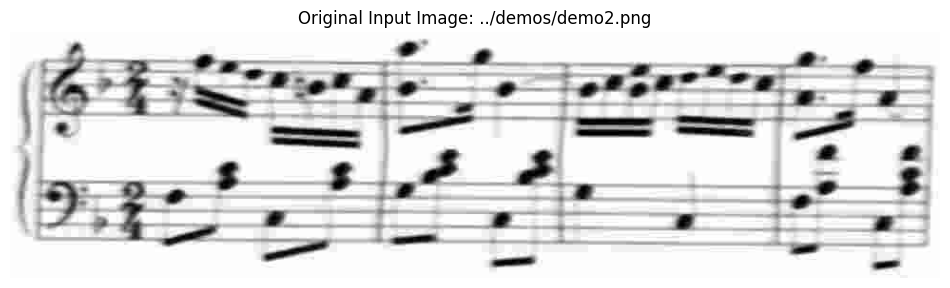

Image preprocessed: ../demos/demo2.png
Original size: 978x259
Tensor size: torch.Size([1, 3, 128, 483])

✅ Image preprocessed successfully!


In [4]:
# Check if demo image exists
if not os.path.exists(img_name):
    print(f"❌ Demo image not found: {img_name}")
    print("Please place a sheet music image at the specified path.")
    print("You can use any sheet music image (PNG, JPG, etc.)")
else:
    # Load and display original image
    print(f"Loading demo image: {img_name}")
    
    # Display original image
    original_img = Image.open(img_name)
    plt.figure(figsize=(12, 6))
    plt.imshow(original_img, cmap='gray')
    plt.title(f"Original Input Image: {img_name}")
    plt.axis('off')
    plt.show()
    
    # Preprocess for model
    try:
        image_tensor = preprocess_image(img_name, target_height=128)
        print("\n✅ Image preprocessed successfully!")
    except Exception as e:
        print(f"❌ Error preprocessing image: {e}")

## 5. Model Inference
Run the MusicTrOCR model to generate BeKern notation predictions.

In [ ]:
# Run inference if model and image are loaded
if 'model' in locals() and 'image_tensor' in locals() and 'vocab_dict' in locals():
    print("Running MusicTrOCR inference...")
    
    try:
        # Generate predictions with corrected EOS detection
        predictions = run_inference(model, image_tensor, vocab_dict, max_length=512)
        
        print(f"\n✅ Inference completed!")
        print(f"Generated sequence shape: {predictions.shape}")
        
        # Display raw token predictions (first 20 tokens)
        raw_tokens = predictions.squeeze().tolist()[:20]
        print(f"\nFirst 20 predicted tokens: {raw_tokens}")
        
    except Exception as e:
        print(f"❌ Error during inference: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ Cannot run inference: model, image, or vocabulary not loaded properly.")
    if 'model' not in locals():
        print("  - Model not loaded")
    if 'image_tensor' not in locals():
        print("  - Image tensor not created")  
    if 'vocab_dict' not in locals():
        print("  - Vocabulary dictionary not loaded")

## 6. Prediction Decoding
Convert model token predictions to readable BeKern notation.

In [6]:
# Decode predictions if available
if 'predictions' in locals() and 'id_to_token' in locals():
    print("Decoding token predictions to BeKern notation...")
    
    try:
        # Decode tokens to BeKern string
        bekern_str = decode_bekern_prediction(predictions, id_to_token, model)
        
        print("\n✅ Decoding completed!")
        print(f"BeKern string length: {len(bekern_str)} characters")
        
        # Display BeKern notation preview
        print("\n--- BeKern Notation Preview ---")
        preview_length = min(300, len(bekern_str))
        print(bekern_str[:preview_length])
        if len(bekern_str) > preview_length:
            print("... (truncated)")
            
        # Token statistics
        tokens = bekern_str.split()
        print(f"\nToken count: {len(tokens)}")
        print(f"Unique tokens: {len(set(tokens))}")
        
        # Most frequent tokens
        from collections import Counter
        token_counts = Counter(tokens)
        print("\nMost frequent tokens:")
        for token, count in token_counts.most_common(10):
            print(f"  '{token}': {count}")
            
    except Exception as e:
        print(f"❌ Error during decoding: {e}")
else:
    print("❌ Cannot decode: predictions not available.")

Decoding token predictions to BeKern notation...
Decoded 8 tokens
Bekern preview: dddd *clefF4 *clefG2 *k[b-] *k[b-] *M2/4 *M2/4 16...

✅ Decoding completed!
BeKern string length: 49 characters

--- BeKern Notation Preview ---
dddd *clefF4 *clefG2 *k[b-] *k[b-] *M2/4 *M2/4 16

Token count: 8
Unique tokens: 6

Most frequent tokens:
  '*k[b-]': 2
  '*M2/4': 2
  'dddd': 1
  '*clefF4': 1
  '*clefG2': 1
  '16': 1


## 7. BeKern to Kern Conversion
Convert BeKern format to standard Kern format for music rendering.

In [7]:
# Convert BeKern to Kern format
if 'bekern_str' in locals():
    print("Converting BeKern to Kern format for rendering...")
    
    try:
        # Convert format
        kern_str = bekern_to_kern(bekern_str)
        
        print("\n✅ Format conversion completed!")
        print(f"Kern string length: {len(kern_str)} characters")
        
        # Display Kern format preview
        print("\n--- Kern Format Preview ---")
        kern_lines = kern_str.split('\n')[:10]  # First 10 lines
        for i, line in enumerate(kern_lines):
            print(f"{i+1:2d}: {line}")
        
        if len(kern_str.split('\n')) > 10:
            print("... (more lines)")
            
    except Exception as e:
        print(f"❌ Error during format conversion: {e}")
else:
    print("❌ Cannot convert format: BeKern string not available.")

Converting BeKern to Kern format for rendering...
Parsed tokens:
  Metadata: ['*clefF4', '*clefG2', '*k[b-]', '*k[b-]', '*M2/4', '*M2/4']
  Music: ['dddd', '16']
Generated Kern structure:
  1: '**kern\t**kern'
  2: '*clefF4\t*clefG2'
  3: '*k[b-]\t*k[b-]'
  4: '*M2/4\t*M2/4'
  5: 'dddd\t16'

✅ Format conversion completed!
Kern string length: 69 characters

--- Kern Format Preview ---
 1: **kern	**kern
 2: *clefF4	*clefG2
 3: *k[b-]	*k[b-]
 4: *M2/4	*M2/4
 5: dddd	16
 6: *-	*-


## 8. Music Score Rendering
Render the Kern notation as a visual music score using Verovio.

Rendering music score from Kern notation...
Kern string to be rendered:
----------------------------------------
**kern	**kern
*clefF4	*clefG2
*k[b-]	*k[b-]
*M2/4	*M2/4
dddd	16
*-	*-
----------------------------------------


Error: Inconsistent rhythm analysis occurring near line 6
Expected durationFromStart to be: 1/4 but found it to be 0
Line: *-	*-



Rendered score saved to: demos/output_score.png
✅ Music score rendered successfully

✅ Music score rendered successfully!
Rendered image shape: (233, 840, 3)


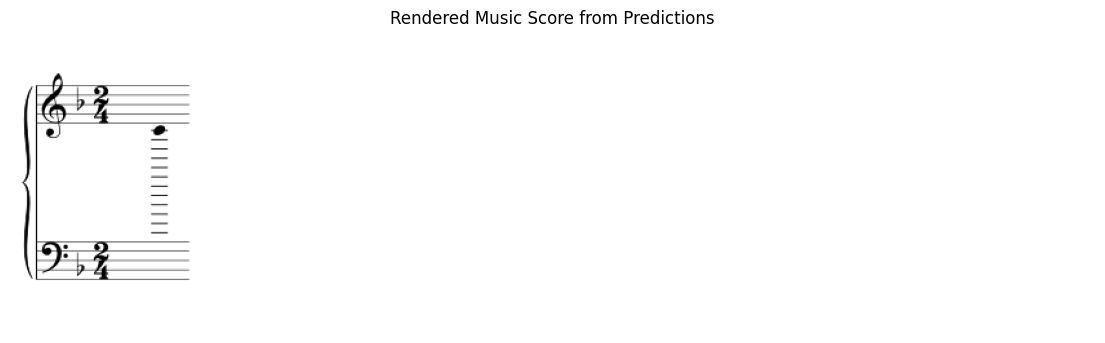

In [8]:
# Render music score
if 'kern_str' in locals():
    print("Rendering music score from Kern notation...")
    
    try:
        # Render score to image
        rendered_score = render_music_score(kern_str, "demos/output_score.png")
        
        if rendered_score is not None:
            print("\n✅ Music score rendered successfully!")
            print(f"Rendered image shape: {rendered_score.shape}")
            
            # Display rendered score
            plt.figure(figsize=(14, 8))
            plt.imshow(rendered_score)
            plt.title("Rendered Music Score from Predictions")
            plt.axis('off')
            plt.show()
        else:
            print("⚠️ Music score rendering failed (Verovio may not be available)")
            print("The BeKern and Kern text outputs above show the symbolic representation.")
            
    except Exception as e:
        print(f"❌ Error during rendering: {e}")
else:
    print("❌ Cannot render: Kern notation not available.")

## 9. Results Comparison
Display side-by-side comparison of input and predicted output.

In [ ]:
# Display final results
if 'bekern_str' in locals() and os.path.exists(img_name):
    print("Displaying final results...")
    
    # Get rendered score if available
    score_image = rendered_score if 'rendered_score' in locals() else None
    
    # Show comparison
    visualize_results(img_name, score_image, bekern_str)
    
    # Summary statistics
    print("\n=== DEMO SUMMARY ===")
    print(f"Input image: {img_name}")
    print(f"Model checkpoint: {ckpt_path}")
    print(f"BeKern tokens generated: {len(bekern_str.split())}")
    print(f"Kern notation lines: {len(kern_str.split(chr(10))) if 'kern_str' in locals() else 'N/A'}")
    print(f"Score visualization: {'✅ Success' if score_image is not None else '❌ Failed'}")
    
else:
    print("❌ Cannot display results: required data not available.")

## 10. Complete Pipeline (Alternative)
Run the entire demo pipeline in one step using the utility function.

In [ ]:
# Alternative: Run complete pipeline at once
# Uncomment and run this cell to execute the entire demo in one step

# results = demo_pipeline(
#     img_path=img_name,
#     ckpt_path=ckpt_path,
#     vocab_path="data/FP_GrandStaff_BeKernw2i.npy"
# )

print("Complete pipeline function available but commented out.")
print("Uncomment the lines above to run the entire demo in one step.")

---

## Conclusion

This demo showcased the MusicTrOCR (Luca Model) capabilities for Optical Music Recognition:

1. **Image Processing**: Converted sheet music image to model input format
2. **Neural Inference**: Used transformer architecture to predict music notation
3. **Sequence Decoding**: Converted model tokens to BeKern symbolic notation
4. **Format Conversion**: Transformed BeKern to standard Kern format
5. **Visual Rendering**: Generated visual music score from symbolic representation

### Model Architecture
- **Vision Encoder**: ConvNeXt-Tiny pre-trained backbone
- **Text Decoder**: 6-layer transformer with cross-attention
- **Vocabulary**: BeKern format with ~300 music symbols
- **Generation**: Autoregressive sequence prediction

### Next Steps
- Try different sheet music images
- Experiment with generation parameters (temperature, max_length)
- Compare with other OMR approaches
- Analyze prediction confidence and error patterns

---